# Přísnost známkování na TIMSS 2007

TIMSS nemá žádný SES -> zde jsem si nějaký vytvořil, uvidíme, nakolik změní výsledky.

## Imports

In [1]:
# nejake standardni importy
import os
import sys
import pyreadstat
import pandas as pd
import numpy as np
import re
from statsmodels.stats.weightstats import DescrStatsW
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
# aby grafy byly rozumně čitelné na obrazovce
plt.rcParams['figure.dpi'] = 90
plt.rcParams['axes.titlesize'] = 11
plt.rcParams['figure.figsize'] = 10, 5
#plt.ioff()
import stata_setup
stata_setup.config('/usr/local/stata17', 'be')
from pystata import stata


  ___  ____  ____  ____  ____ ®
 /__    /   ____/   /   ____/      17.0
___/   /   /___/   /   /___/       BE—Basic Edition

 Statistics and Data Science       Copyright 1985-2021 StataCorp LLC
                                   StataCorp
                                   4905 Lakeway Drive
                                   College Station, Texas 77845 USA
                                   800-STATA-PC        https://www.stata.com
                                   979-696-4600        stata@stata.com

Stata license: Single-user , expiring 16 Apr 2023
Serial number: 301709041865
  Licensed to: Tomas Protivinsky
               CERGE-EI

Notes:
      1. Unicode is supported; see help unicode_advice.


In [2]:
def nanaverage(x, weights=None):    
    if weights is None:
        if len(x.shape) == 1:
            return np.nanmean(x)
        else:
            res = np.nanmean(x, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res
    else:
        w = x[weights]
        x = x.drop(columns=[weights])
        mask = np.isnan(x)
        xm = np.ma.masked_array(x, mask=mask)
        if len(x.shape) == 1:
            return np.ma.average(xm, weights=w)
        else:
            res = np.ma.average(xm, weights=w, axis=0)
            return pd.Series(res, x.columns) if isinstance(x, pd.DataFrame) else res            

In [3]:
def logistic(x):
    return 1 / (1 + np.exp(-x))

## Stata data loading

In [4]:
%%stata -qui

// kod
clear all
version 17
set more off
// global path to data
global PATHD="/mnt/d/projects/idea/data"

// load students data
use ${PATHD}/TIMSS/2007/CZ/czt07_zak8.dta, clear

gen gr_matematika = bs4nznma
recode gr_matematika 0 8 9=.
egen gr_matematika_z = std(gr_matematika)

recode itsex 1=1 2=0, gen(girl)

// multiple imputations to handle plausible values
gen math=1/0
mi import wide, imputed(math=bsmmat0*) clear

mi passive: egen mathz = std(math)

drop if missing(gr_matematika)
// dropni víceletá gymnázia
drop if typ==2 

// jak fungují váhy?
gen wgt1 = wgtadj1 * wgtfac1
gen wgt2 = wgtadj2 * wgtfac2
gen wgt3 = wgtadj3 * wgtfac3

gen wgt12 = wgt1 * wgt2

// jen na ověření, zdali mi to skutečně dá totwgt -> ano, dá
gen wgt123 = wgt1 * wgt2 * wgt3

recode bsnghfsg 6 7=1 1 2 3 4 5=0 8 99=., gen(chcevs)

// chci vytvořit nějaký základní SES
egen book_z = std(bs4gbook)

recode bsdgedup 1=5 2=4 3=3 4=2 5=1 6=.
egen edup_z = std(bsdgedup)

recode bs4gth0* (2=0)

foreach var of varlist bs4gth0* {
	sum `var'
	replace `var' = r(mean) if missing(`var')
}

egen poss = rowmean(bs4gth0*)
egen poss_z = std(poss)

gen ses_raw = edup_z + book_z + poss_z
egen ses = std(ses_raw)


In [5]:
%%stata -qui
// vytvoř BSMJ index
// http://www.harryganzeboom.nl/isco08/index.htm

recode bs4npoza (     0=51.25) (   100=60.92) (   110=60.92) (   200=51.63) (   210=51.63) (   300=29.18) (   310=29.18) (  1000=65.12) (  1100=71.72) (  1110=74.50) (  1111=68.77) (  1112=78.76) (  1113=64.98) (  1114=71.29) (  1120=70.34) (  1200=72.94) (  1210=72.24) (  1211=73.38) (  1212=74.79) (  1213=70.57) (  1219=68.54) (  1220=73.71) (  1221=71.39) (  1222=75.25) (  1223=81.92) (  1300=65.25) (  1310=49.48) (  1311=49.48) (  1312=49.48) (  1320=61.57) (  1321=65.42) (  1322=61.57) (  1323=59.89) (  1324=58.07) (  1330=78.86) (  1340=65.01) (  1341=65.01) (  1342=65.01) (  1343=65.01) (  1344=65.01) (  1345=65.01) (  1346=65.01) (  1349=65.01) (  1400=51.01) (  1410=43.85) (  1411=43.85) (  1412=43.85) (  1420=51.56) (  1430=51.01) (  1431=51.01) (  1439=51.01) (  2000=76.24) (  2100=79.49) (  2110=84.16) (  2111=84.61) (  2112=84.61) (  2113=83.50) (  2114=86.81) (  2120=81.78) (  2130=80.46) (  2131=80.46) (  2132=78.17) (  2133=80.46) (  2140=79.05) (  2141=79.05) (  2142=81.40) (  2143=79.05) (  2144=77.10) (  2145=82.31) (  2146=79.31) (  2149=78.69) (  2150=80.75) (  2151=80.78) (  2152=80.75) (  2153=80.75) (  2160=79.74) (  2161=79.74) (  2162=79.74) (  2163=79.74) (  2164=79.74) (  2165=72.96) (  2166=79.74) (  2200=76.98) (  2210=88.70) (  2211=88.70) (  2212=81.92) (  2220=68.70) (  2221=68.70) (  2222=68.70) (  2230=76.98) (  2240=76.98) (  2250=84.14) (  2260=75.43) (  2261=88.31) (  2262=81.13) (  2263=75.43) (  2264=67.94) (  2265=65.23) (  2266=75.43) (  2267=75.43) (  2269=75.43) (  2300=75.54) (  2310=85.41) (  2320=72.30) (  2330=82.41) (  2340=71.45) (  2341=76.49) (  2342=58.77) (  2350=68.88) (  2351=77.88) (  2352=70.89) (  2353=68.88) (  2354=68.88) (  2355=68.88) (  2356=68.88) (  2359=66.42) (  2400=73.91) (  2410=75.50) (  2411=76.65) (  2412=75.50) (  2413=75.50) (  2420=70.09) (  2421=70.09) (  2422=72.94) (  2423=68.55) (  2424=70.09) (  2430=73.91) (  2431=73.91) (  2432=73.91) (  2433=73.91) (  2434=73.91) (  2500=75.13) (  2510=74.66) (  2511=74.66) (  2512=74.66) (  2513=74.66) (  2514=74.66) (  2519=74.70) (  2520=75.13) (  2521=75.13) (  2522=75.13) (  2523=75.13) (  2529=75.13) (  2600=75.67) (  2610=85.13) (  2611=86.72) (  2612=88.96) (  2619=81.05) (  2620=71.55) (  2621=77.19) (  2622=70.40) (  2630=77.24) (  2631=80.92) (  2632=83.09) (  2633=83.81) (  2634=85.85) (  2635=70.50) (  2636=71.55) (  2640=72.83) (  2641=72.83) (  2642=72.83) (  2643=80.92) (  2650=63.31) (  2651=61.82) (  2652=64.44) (  2653=61.82) (  2654=63.31) (  2655=70.10) (  2656=54.00) (  2659=37.59) (  3000=56.03) (  3100=52.40) (  3110=53.60) (  3111=55.03) (  3112=59.35) (  3113=51.92) (  3114=56.38) (  3115=53.77) (  3116=59.45) (  3117=62.79) (  3118=50.73) (  3119=51.35) (  3120=38.18) (  3121=37.83) (  3122=40.54) (  3123=37.83) (  3130=33.66) (  3131=46.73) (  3132=37.22) (  3133=33.66) (  3134=33.66) (  3135=33.66) (  3139=31.46) (  3140=54.86) (  3141=54.86) (  3142=58.05) (  3143=54.86) (  3150=63.29) (  3151=56.41) (  3152=52.70) (  3153=73.71) (  3154=69.24) (  3155=67.04) (  3200=55.40) (  3210=54.92) (  3211=57.04) (  3212=57.37) (  3213=48.66) (  3214=54.92) (  3220=56.98) (  3221=56.00) (  3222=51.93) (  3230=51.57) (  3240=24.79) (  3250=53.15) (  3251=47.83) (  3252=53.15) (  3253=53.15) (  3254=59.85) (  3255=53.15) (  3256=44.92) (  3257=57.25) (  3258=53.15) (  3259=61.91) (  3300=57.64) (  3310=57.13) (  3311=72.27) (  3312=59.76) (  3313=55.25) (  3314=69.76) (  3315=57.68) (  3320=57.97) (  3321=60.29) (  3322=57.03) (  3323=56.35) (  3324=61.18) (  3330=56.64) (  3331=54.62) (  3332=56.64) (  3333=60.44) (  3334=62.39) (  3339=59.89) (  3340=57.99) (  3341=62.13) (  3342=57.99) (  3343=54.55) (  3344=57.99) (  3350=61.60) (  3351=65.64) (  3352=67.11) (  3353=54.27) (  3354=59.18) (  3355=63.03) (  3359=64.40) (  3400=52.57) (  3410=54.35) (  3411=57.00) (  3412=52.72) (  3413=54.54) (  3420=50.90) (  3421=50.90) (  3422=50.90) (  3423=50.90) (  3430=50.15) (  3431=50.15) (  3432=57.64) (  3433=50.15) (  3434=50.15) (  3435=50.15) (  3500=60.93) (  3510=62.45) (  3511=61.07) (  3512=62.45) (  3513=62.45) (  3514=62.45) (  3520=56.50) (  3521=56.57) (  3522=56.50) (  4000=43.51) (  4100=43.33) (  4110=43.33) (  4120=44.94) (  4130=44.87) (  4131=48.27) (  4132=40.56) (  4200=41.22) (  4210=43.06) (  4211=48.10) (  4212=48.82) (  4213=50.05) (  4214=50.05) (  4220=39.02) (  4221=49.30) (  4222=39.02) (  4223=38.58) (  4224=39.02) (  4225=39.02) (  4226=39.02) (  4227=39.02) (  4229=39.02) (  4300=44.08) (  4310=50.57) (  4311=50.37) (  4312=57.38) (  4313=50.57) (  4320=36.10) (  4321=32.50) (  4322=41.63) (  4323=41.27) (  4400=42.30) (  4410=42.30) (  4411=42.30) (  4412=27.52) (  4413=51.77) (  4414=54.67) (  4415=42.30) (  4416=42.30) (  4419=44.72) (  5000=29.32) (  5100=27.57) (  5110=45.46) (  5111=46.76) (  5112=38.44) (  5113=47.42) (  5120=24.53) (  5130=25.04) (  5131=25.04) (  5132=25.04) (  5140=31.08) (  5141=31.08) (  5142=31.08) (  5150=25.46) (  5151=25.20) (  5152=32.20) (  5153=21.82) (  5160=30.59) (  5161=32.75) (  5162=24.07) (  5163=34.25) (  5164=30.59) (  5165=30.59) (  5169=32.75) (  5200=29.73) (  5210=26.64) (  5211=28.84) (  5212=23.53) (  5220=29.47) (  5221=35.34) (  5222=44.14) (  5223=28.48) (  5230=30.90) (  5240=39.04) (  5241=39.73) (  5242=39.04) (  5243=39.04) (  5244=38.88) (  5245=39.04) (  5246=39.04) (  5249=39.04) (  5300=25.09) (  5310=24.98) (  5311=24.98) (  5312=24.98) (  5320=26.64) (  5321=26.64) (  5322=21.64) (  5329=26.64) (  5400=36.86) (  5410=36.86) (  5411=46.38) (  5412=51.50) (  5413=48.13) (  5414=23.80) (  5419=33.83) (  6000=19.20) (  6100=19.41) (  6110=16.34) (  6111=11.56) (  6112=18.95) (  6113=20.91) (  6114=12.87) (  6120=22.21) (  6121=21.13) (  6122=19.83) (  6123=28.04) (  6129=28.04) (  6130=17.79) (  6200=18.29) (  6210=19.78) (  6220=16.33) (  6221=17.00) (  6222=13.35) (  6223=20.69) (  6224=11.01) (  6300=11.01) (  6310=11.01) (  6320=11.01) (  6330=11.01) (  6340=11.01) (  7000=28.53) (  7100=25.39) (  7110=25.94) (  7111=33.76) (  7112=22.57) (  7113=23.96) (  7114=21.96) (  7115=26.62) (  7119=26.92) (  7120=25.26) (  7121=22.16) (  7122=22.75) (  7123=18.02) (  7124=27.81) (  7125=24.09) (  7126=29.16) (  7127=25.26) (  7130=23.63) (  7131=22.77) (  7132=24.49) (  7133=30.47) (  7200=29.81) (  7210=27.61) (  7211=28.03) (  7212=28.52) (  7213=25.51) (  7214=26.60) (  7215=28.60) (  7220=29.84) (  7221=25.63) (  7222=33.16) (  7223=28.70) (  7224=33.90) (  7230=31.15) (  7231=30.78) (  7232=47.74) (  7233=31.72) (  7234=31.15) (  7300=31.00) (  7310=30.35) (  7311=35.70) (  7312=35.66) (  7313=28.12) (  7314=24.43) (  7315=25.78) (  7316=30.14) (  7317=28.95) (  7318=28.97) (  7319=30.35) (  7320=31.50) (  7321=35.33) (  7322=30.49) (  7323=28.24) (  7400=37.34) (  7410=36.97) (  7411=36.35) (  7412=36.92) (  7413=39.45) (  7420=41.68) (  7421=43.76) (  7422=36.92) (  7500=23.97) (  7510=23.46) (  7511=20.95) (  7512=23.57) (  7513=27.30) (  7514=22.79) (  7515=34.12) (  7516=26.96) (  7520=23.65) (  7521=21.81) (  7522=25.23) (  7523=20.78) (  7530=22.03) (  7531=23.47) (  7532=24.88) (  7533=21.24) (  7534=22.25) (  7535=28.08) (  7536=18.07) (  7540=43.19) (  7541=27.30) (  7542=27.30) (  7543=43.19) (  7544=55.96) (  7549=43.19) (  8000=25.45) (  8100=23.41) (  8110=31.44) (  8111=35.07) (  8112=25.11) (  8113=35.82) (  8114=26.13) (  8120=25.91) (  8121=30.32) (  8122=22.36) (  8130=29.30) (  8131=29.14) (  8132=31.34) (  8140=25.49) (  8141=23.09) (  8142=24.85) (  8143=32.67) (  8150=16.80) (  8151=17.85) (  8152=18.03) (  8153=13.24) (  8154=16.08) (  8155=20.35) (  8156=20.35) (  8157=16.80) (  8159=21.20) (  8160=18.13) (  8170=22.40) (  8171=27.25) (  8172=19.08) (  8180=24.15) (  8181=21.13) (  8182=23.19) (  8183=24.15) (  8189=24.16) (  8200=24.93) (  8210=24.93) (  8211=27.91) (  8212=23.88) (  8219=24.68) (  8300=26.80) (  8310=38.80) (  8311=45.76) (  8312=29.80) (  8320=30.11) (  8321=28.48) (  8322=30.34) (  8330=25.71) (  8331=26.85) (  8332=25.95) (  8340=21.08) (  8341=13.34) (  8342=24.45) (  8343=24.80) (  8344=18.08) (  8350=37.92) (  9000=16.50) (  9100=14.64) (  9110=14.64) (  9111=16.38) (  9112=14.21) (  9120=14.57) (  9121=14.82) (  9122=14.57) (  9123=14.57) (  9129=14.57) (  9200=11.87) (  9210=11.74) (  9211=11.74) (  9212=11.74) (  9213=11.74) (  9214=11.74) (  9215=12.01) (  9216=12.34) (  9300=17.53) (  9310=16.39) (  9311=15.35) (  9312=17.56) (  9313=15.35) (  9320=17.55) (  9321=17.55) (  9329=16.36) (  9330=19.66) (  9331=20.27) (  9332=16.89) (  9333=17.69) (  9334=19.66) (  9400=16.50) (  9410=16.50) (  9411=16.50) (  9412=16.50) (  9500=23.43) (  9510=13.72) (  9520=25.20) (  9600=24.07) (  9610=14.39) (  9611=14.39) (  9612=14.39) (  9613=13.87) (  9620=27.91) (  9621=25.06) (  9622=27.91) (  9623=30.99) (  9624=27.91) (  9629=27.91) (nonmissing = .), gen(bsmj)



// ekvivalent BSMJ -- toto je založeno na ISCO 88 conversion described at http://www.harryganzeboom.nl/isco88/index.htm
recode bs4npoza (1000=55) (1100=70) (1110=77) (1120=77) (1130=66) (1140=58) (1141=58) (1142=58) (1143=58) (1200=68) (1210=70) (1220=67) (1221=67) (1222=67) (1223=67) (1224=59) (1225=59) (1226=59) (1227=87) (1228=59) (1229=67) (1230=61) (1231=69) (1232=69) (1233=56) (1234=69) (1235=69) (1236=69) (1237=69) (1239=69) (1240=58) (1250=64) (1251=70) (1252=60) (1300=51) (1310=51) (1311=43) (1312=56) (1313=51) (1314=49) (1315=44) (1316=51) (1317=51) (1318=51) (1319=51) (2000=70) (2100=69) (2110=74) (2111=74) (2112=74) (2113=74) (2114=74) (2120=71) (2121=71) (2122=71) (2130=71) (2131=71) (2132=71) (2139=71) (2140=73) (2141=69) (2142=69) (2143=68) (2144=68) (2145=67) (2146=71) (2147=67) (2148=56) (2149=69) (2200=80) (2210=78) (2211=77) (2212=77) (2213=79) (2220=85) (2221=88) (2222=85) (2223=83) (2224=74) (2229=85) (2230=43) (2300=69) (2310=77) (2320=69) (2321=70) (2322=66) (2330=66) (2331=66) (2332=43) (2340=66) (2350=66) (2351=70) (2352=70) (2359=65) (2400=68) (2410=69) (2411=69) (2412=69) (2419=69) (2420=85) (2421=85) (2422=90) (2429=82) (2430=65) (2431=65) (2432=65) (2440=65) (2441=78) (2442=71) (2443=71) (2444=65) (2445=71) (2446=51) (2450=61) (2451=65) (2452=54) (2453=64) (2454=64) (2455=64) (2460=53) (3000=54) (3100=50) (3110=49) (3111=45) (3112=45) (3113=46) (3114=46) (3115=54) (3116=54) (3117=54) (3118=51) (3119=53) (3120=52) (3121=52) (3122=52) (3123=52) (3130=52) (3131=48) (3132=57) (3133=57) (3139=52) (3140=57) (3141=52) (3142=52) (3143=69) (3144=69) (3145=50) (3150=50) (3151=50) (3152=50) (3200=48) (3210=50) (3211=50) (3212=50) (3213=50) (3220=55) (3221=51) (3222=51) (3223=51) (3224=60) (3225=51) (3226=60) (3227=51) (3228=51) (3229=51) (3230=38) (3231=38) (3232=38) (3240=49) (3241=51) (3242=38) (3300=38) (3310=38) (3320=38) (3330=38) (3340=38) (3400=55) (3410=55) (3411=61) (3412=54) (3413=59) (3414=56) (3415=56) (3416=50) (3417=56) (3419=55) (3420=55) (3421=55) (3422=55) (3423=55) (3429=55) (3430=54) (3431=54) (3432=59) (3433=51) (3434=61) (3439=54) (3440=56) (3441=56) (3442=57) (3443=56) (3444=46) (3449=56) (3450=56) (3451=55) (3452=56) (3460=43) (3470=52) (3471=53) (3472=64) (3473=50) (3474=50) (3475=54) (3480=38) (4000=45) (4100=45) (4110=51) (4111=51) (4112=50) (4113=50) (4114=51) (4115=53) (4120=51) (4121=51) (4122=51) (4130=36) (4131=32) (4132=43) (4133=45) (4140=39) (4141=39) (4142=39) (4143=39) (4144=39) (4190=39) (4200=49) (4210=48) (4211=53) (4212=46) (4213=40) (4214=40) (4215=40) (4220=52) (4221=52) (4222=52) (4223=52) (5000=40) (5100=38) (5110=34) (5111=34) (5112=34) (5113=34) (5120=32) (5121=30) (5122=30) (5123=34) (5130=25) (5131=25) (5132=25) (5133=25) (5139=25) (5140=30) (5141=29) (5142=19) (5143=54) (5149=19) (5150=43) (5151=43) (5152=43) (5160=47) (5161=42) (5162=50) (5163=40) (5164=40) (5169=40) (5200=43) (5210=43) (5220=43) (5230=37) (6000=23) (6100=23) (6110=23) (6111=23) (6112=23) (6113=23) (6114=23) (6120=23) (6121=23) (6122=23) (6123=23) (6124=23) (6129=23) (6130=23) (6131=23) (6132=27) (6133=28) (6134=28) (6140=22) (6141=22) (6142=22) (6150=28) (6151=28) (6152=28) (6153=28) (6154=28) (6200=16) (6210=16) (7000=34) (7100=31) (7110=30) (7111=30) (7112=30) (7113=27) (7120=30) (7121=29) (7122=29) (7123=26) (7124=29) (7129=30) (7130=34) (7131=19) (7132=30) (7133=31) (7134=34) (7135=26) (7136=33) (7137=37) (7140=29) (7141=29) (7142=32) (7143=29) (7200=34) (7210=31) (7211=29) (7212=30) (7213=33) (7214=30) (7215=30) (7216=30) (7220=35) (7221=33) (7222=40) (7223=34) (7224=24) (7230=34) (7231=34) (7232=42) (7233=33) (7234=23) (7240=40) (7241=40) (7242=39) (7243=41) (7244=40) (7245=38) (7300=34) (7310=38) (7311=38) (7312=38) (7313=38) (7320=28) (7321=27) (7322=29) (7323=29) (7324=29) (7330=29) (7331=29) (7332=29) (7340=40) (7341=40) (7342=40) (7343=42) (7344=40) (7345=37) (7346=38) (7400=33) (7410=30) (7411=30) (7412=31) (7413=30) (7414=30) (7415=30) (7416=30) (7420=33) (7421=33) (7422=33) (7423=33) (7424=33) (7430=36) (7431=29) (7432=29) (7433=45) (7434=36) (7435=36) (7436=33) (7437=28) (7440=31) (7441=31) (7442=31) (7500=42) (7510=42) (7520=39) (7530=26) (8000=31) (8100=30) (8110=35) (8111=35) (8112=35) (8113=35) (8120=30) (8121=31) (8122=30) (8123=28) (8124=30) (8130=22) (8131=22) (8139=22) (8140=27) (8141=27) (8142=27) (8143=27) (8150=35) (8151=35) (8152=35) (8153=35) (8154=35) (8155=35) (8159=35) (8160=32) (8161=33) (8162=27) (8163=33) (8170=26) (8171=26) (8172=26) (8200=32) (8210=36) (8211=36) (8212=30) (8220=30) (8221=30) (8222=30) (8223=30) (8224=30) (8229=30) (8230=30) (8231=30) (8232=30) (8240=29) (8250=38) (8251=38) (8252=38) (8253=38) (8260=30) (8261=29) (8262=29) (8263=32) (8264=24) (8265=32) (8266=32) (8269=32) (8270=29) (8271=29) (8272=29) (8273=29) (8274=29) (8275=29) (8276=29) (8277=29) (8278=29) (8279=29) (8280=31) (8281=30) (8282=34) (8283=34) (8284=30) (8285=30) (8286=30) (8290=26) (8300=32) (8310=36) (8311=41) (8312=32) (8320=34) (8321=30) (8322=30) (8323=30) (8324=34) (8330=26) (8331=26) (8332=26) (8333=28) (8334=28) (8340=32) (8400=24) (9000=20) (9100=25) (9110=29) (9111=29) (9112=28) (9113=29) (9120=28) (9130=16) (9131=16) (9132=16) (9133=16) (9140=23) (9141=23) (9142=23) (9150=27) (9151=25) (9152=27) (9153=27) (9160=23) (9161=23) (9162=23) (9200=16) (9210=16) (9211=16) (9212=16) (9213=16) (9300=23) (9310=21) (9311=21) (9312=21) (9313=21) (9320=20) (9321=20) (9322=24) (9330=29) (9331=22) (9332=22) (9333=30) (nonmissing = .), gen(bsmj88)

In [6]:
%stata count

  4,252


## Basic descriptives

In [7]:
df = stata.pdataframe_from_data()

# Stata uses something like 1e307 as nan in the converted frame
for c in df.columns:
    if df[c].dtype == np.float_:
        df.loc[df[c] > 1e300, c] = np.nan

In [8]:
df.shape

(4252, 437)

In [9]:
df.head()

,idcntry,idschool,idclass,idgrade,idstud,itbirthm,itbirthy,itsex,idbook,itadmini,...,wgt123,chcevs,book_z,edup_z,poss,poss_z,ses_raw,ses,bsmj,bsmj88
0,203,19,1901,8,190101,8,1992,1,14,3,...,19.644447,0.0,-1.020796,-0.576265,0.555556,-1.445550,-3.042611,-1.506533,NaN,NaN
1,203,19,1901,8,190102,4,1993,1,1,3,...,19.644447,0.0,-1.020796,NaN,0.444444,-2.129079,NaN,NaN,NaN,NaN
2,203,19,1901,8,190104,4,1993,2,3,3,...,19.644447,0.0,0.890635,-3.052093,0.777778,-0.078493,-2.239951,-1.117007,27.809999,29.0
3,203,19,1901,8,190105,12,1992,2,4,3,...,19.644447,NaN,-0.065081,-0.576265,0.777778,-0.078493,-0.719839,-0.379306,NaN,NaN
4,203,19,1901,8,190106,9,1992,2,5,3,...,19.644447,1.0,1.846351,0.661650,0.888889,0.605035,3.113035,1.480765,57.000000,61.0


### Lineplot

In [11]:
%stata mi estimate, dots: reg math ibn.gr_matematika [pw = totwgt], noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.2536
                                                Largest FMI       =     0.2851
                                                Complete DF       =       4247
DF adjustment:   Small sample                   DF:     min       =      57.62
                                                        avg       =     192.73
                                                        max       =     546.14
Model F test:       Equal FMI                   F(   5,  309.9)   =   53606.21
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [92]:
%stata reg bsmmat01 ibn.gr_matematika, noconstant


      Source |       SS           df       MS      Number of obs   =     4,252
-------------+----------------------------------   F(5, 4247)      =  83460.87
       Model |  1.0584e+09         5   211689464   Prob > F        =    0.0000
    Residual |  10772055.5     4,247  2536.39169   R-squared       =    0.9899
-------------+----------------------------------   Adj R-squared   =    0.9899
       Total |  1.0692e+09     4,252  251462.694   Root MSE        =    50.363

------------------------------------------------------------------------------
    bsmmat01 | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a |
          1  |   559.5914   2.039122   274.43   0.000     555.5937    563.5892
          2  |   524.9432   1.307789   401.40   0.000     522.3793    527.5072
          3  |     476.81   1.369682   348.12   0.000     474.1247    479.4953
          4  |   434.9012   1.84514

### Variance decomposition

In [19]:
for i in range(1,6):
    df[f'bsmmat0{i}z'] = (df[f'bsmmat0{i}'] - df[f'bsmmat0{i}'].mean()) / df[f'bsmmat0{i}'].std()
    
df['MATH_MEAN'] = np.mean(df[[f'bsmmat0{i}' for i in range(1,6)]], axis=1)
df['MATH_Z'] = np.mean(df[[f'bsmmat0{i}z' for i in range(1,6)]], axis=1)

In [159]:
df.head()

,idcntry,idschool,idclass,idgrade,idstud,itbirthm,itbirthy,itsex,idbook,itadmini,...,bsmmat02z,bsmmat03z,bsmmat04z,bsmmat05z,MATH_MEAN,MATH_Z,gr_matematika_pred,gr_matematika_resid,prisnost,prisnost_bin
0,203,19,1901,8,190101,8,1992,1,14,3,...,-1.063847,-1.413344,-1.100273,-0.435148,431.856396,-0.984704,3.162976,-0.162976,-0.407997,0.0
1,203,19,1901,8,190102,4,1993,1,1,3,...,-1.114009,-1.013961,-1.487598,-1.253132,415.466144,-1.233517,NaN,NaN,-0.407997,0.0
2,203,19,1901,8,190104,4,1993,2,3,3,...,-0.126679,-0.533098,0.113639,-0.129654,484.665594,-0.197520,2.814549,1.185451,-0.407997,0.0
3,203,19,1901,8,190105,12,1992,2,4,3,...,0.079794,-0.304166,-0.261423,-0.282156,484.701569,-0.197956,2.757632,-1.757632,-0.407997,0.0
4,203,19,1901,8,190106,9,1992,2,5,3,...,2.218427,2.090151,2.323827,1.551221,635.165540,2.051122,0.911005,0.088995,-0.407997,0.0


In [162]:
grand_mean = nanaverage(df[['MATH_MEAN', 'totwgt']], weights='totwgt')[0]
grand_mean

494.7528415871075

In [169]:
ss_total = np.sum(np.mean((df[[f'bsmmat0{i}' for i in range(1, 6)]].values - grand_mean) ** 2, axis=1) * df['totwgt'])
ss_total

439390115.45306855

In [170]:
ss_pvs = np.sum(np.mean((df[[f'bsmmat0{i}' for i in range(1, 6)]].values - df[['MATH_MEAN']].values) ** 2, axis=1) * df['totwgt'])
ss_pvs

38025113.33987114

In [171]:
# this should be the remaining variance after removing PVs
ss_total_nopv = np.sum((df['MATH_MEAN'] - grand_mean) ** 2 * df['totwgt'])
ss_total_nopv

401365002.11319745

In [173]:
grade_means = df.groupby('gr_matematika')[['MATH_MEAN', 'totwgt']].apply(nanaverage, weights='totwgt')['MATH_MEAN'].rename('MATH_GRADE_MEAN').reset_index()
grade_means

,gr_matematika,MATH_GRADE_MEAN
0,1.0,558.590757
1,2.0,522.435353
2,3.0,474.887340
3,4.0,433.677847
4,5.0,403.618591


In [178]:
df = pd.merge(df, grade_means)

In [176]:
grade_weight = df.groupby('gr_matematika')['totwgt'].sum()
grades = pd.merge(grade_means, grade_weight.reset_index())
grades

,gr_matematika,MATH_GRADE_MEAN,totwgt
0,1.0,558.590757,14504.993717
1,2.0,522.435353,34648.522828
2,3.0,474.887340,31343.801844
3,4.0,433.677847,18170.749775
4,5.0,403.618591,1675.417099


In [177]:
ss_bw_grades = np.sum((grades['MATH_GRADE_MEAN'] - grand_mean) ** 2 * grades['totwgt'])
ss_bw_grades

179728076.40657786

In [180]:
ss_wn_grades = np.sum((df['MATH_MEAN'] - df['MATH_GRADE_MEAN']) ** 2 * df['totwgt'])
ss_wn_grades

221636925.70661968

In [181]:
ss_bw_grades + ss_wn_grades + ss_pvs

439390115.45306873

In [182]:
ss_total

439390115.45306855

In [187]:
100 * np.array([ss_pvs, ss_wn_grades, ss_bw_grades]) / ss_total

array([ 8.65406663, 50.44194621, 40.90398716])

In [ ]:
# schools and classes

In [199]:
school_means = df.groupby('idschool')[['MATH_MEAN', 'totwgt']].apply(nanaverage, weights='totwgt')['MATH_MEAN'].rename('MATH_SCHOOL_MEAN').reset_index()
df = pd.merge(df, school_means)

school_weight = df.groupby('idschool')['totwgt'].sum()
schools = pd.merge(school_means, school_weight.reset_index())
schools.head()

,idschool,MATH_SCHOOL_MEAN,totwgt
0,19,494.681629,275.022236
1,20,454.292750,201.594129
2,36,480.315983,725.325525
3,38,555.507545,562.229513
4,40,499.882666,778.949544


In [200]:
class_means = df.groupby('idclass')[['MATH_MEAN', 'totwgt']].apply(nanaverage, weights='totwgt')['MATH_MEAN'].rename('MATH_CLASS_MEAN').reset_index()
df = pd.merge(df, class_means)

class_weight = df.groupby('idclass')['totwgt'].sum()
classes = pd.merge(class_means, class_weight.reset_index())
classes.head()

,idclass,MATH_CLASS_MEAN,totwgt
0,1901,494.681629,275.022236
1,2001,430.072323,100.614129
2,2003,478.425422,100.980000
3,3602,467.207322,354.603596
4,3605,492.854703,370.721930


In [201]:
ss_bw_schools = np.sum((schools['MATH_SCHOOL_MEAN'] - grand_mean) ** 2 * schools['totwgt'])
ss_wn_schools = np.sum((df['MATH_MEAN'] - df['MATH_SCHOOL_MEAN']) ** 2 * df['totwgt'])
ss_bw_schools, ss_wn_schools

(60804925.82836789, 340560076.2848295)

In [202]:
ss_bw_classes = np.sum((classes['MATH_CLASS_MEAN'] - grand_mean) ** 2 * classes['totwgt'])
ss_wn_classes = np.sum((df['MATH_MEAN'] - df['MATH_CLASS_MEAN']) ** 2 * df['totwgt'])
ss_bw_classes, ss_wn_classes

(89353221.83283895, 312011780.2803585)

In [203]:
100 * np.array([ss_bw_grades, ss_wn_grades, ss_bw_schools, ss_wn_schools, ss_bw_classes, ss_wn_classes]) / ss_total_nopv

array([44.77920981, 55.22079019, 15.14953359, 84.85046641, 22.26233512,
       77.73766488])

In [189]:
# how about schools?
# actually, are there multiple classes per school at all?

In [193]:
foo = df[['idclass', 'idschool']].drop_duplicates()

In [197]:
foo.shape

(197, 2)

In [196]:
foo['idclass'].unique().shape

(197,)

In [198]:
foo['idschool'].unique().shape

(133,)

In [206]:
%%stata
local M = 5
scalar r2 = 0
qui mi xeq 1/`M': reg math ibn.gr_matematika [pw = totwgt], noconstant; scalar r2 = r2 + atanh(sqrt(e(r2)))
scalar r2 = tanh(r2/`M')^2
di as txt "R2 using Fisher's z over imputed data = " as res r2


. local M = 5

. scalar r2 = 0

. qui mi xeq 1/`M': reg math ibn.gr_matematika [pw = totwgt], noconstant; scala
> r r2 = r2 + atanh(sqrt(e(r2)))

. scalar r2 = tanh(r2/`M')^2

. di as txt "R2 using Fisher's z over imputed data = " as res r2
R2 using Fisher's z over imputed data = .98962132

. 


In [208]:
%stata mi estimate, dots: reg math ibn.gr_matematika [pw = totwgt], noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.2536
                                                Largest FMI       =     0.2851
                                                Complete DF       =       4247
DF adjustment:   Small sample                   DF:     min       =      57.62
                                                        avg       =     192.73
                                                        max       =     546.14
Model F test:       Equal FMI                   F(   5,  309.9)   =   53606.21
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [209]:
er = stata.get_ereturn()
b_mi = er['e(b_mi)']
V_mi = er['e(V_mi)']
dfr = er['e(df_r_mi)']
coefs = b_mi[0]
std_errs = np.sqrt(np.diag(V_mi))

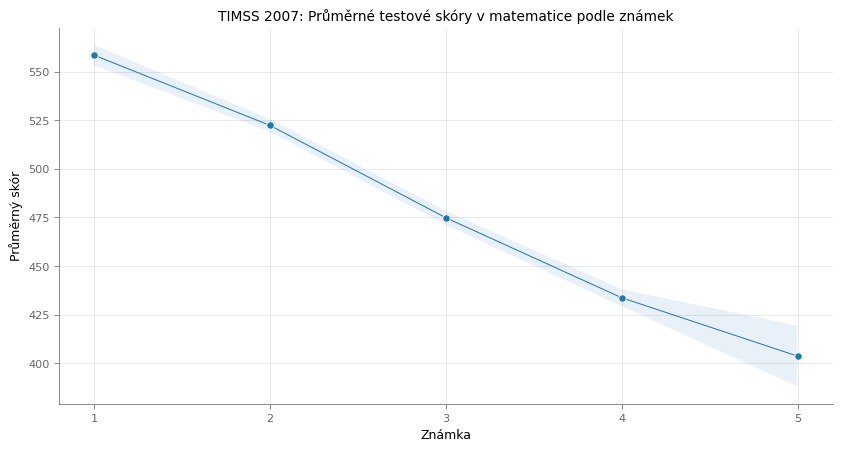

In [211]:
foo = pd.DataFrame({'grade': range(1, 6), 'coef': coefs, 'se': std_errs})

foo['lower'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['upper'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']

fig, ax = plt.subplots()
sns.lineplot(x='grade', y='coef', data=foo, marker='o')
plt.fill_between(foo['grade'], foo['lower'], foo['upper'], alpha=0.1)
ax.set(xlabel='Známka', ylabel='Průměrný skór')
ax.set_title('TIMSS 2007: Průměrné testové skóry v matematice podle známek')
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1.00))

In [212]:
ax.get_figure().savefig('output/prisnost-znamkovani/13-timss-prumerne-skory.png')
ax.get_figure().savefig('output/prisnost-znamkovani/13-timss-prumerne-skory.pdf')

In [213]:
foo

,grade,coef,se,lower,upper
0,1,558.590757,2.654785,553.367075,563.814438
1,2,522.435353,1.626642,519.234695,525.636010
2,3,474.887340,1.842092,471.262753,478.511927
3,4,433.677847,2.191205,429.366327,437.989366
4,5,403.618591,7.959785,387.956540,419.280643


### Boxplots

In [10]:
boxplots = []

bxp_def = {
    'med': 0.5,
    'q1': 0.25,
    'q3': 0.75,
    'whislo': 0.05,
    'whishi': 0.95
}


for gr in range(1, 6):
    print(f'running {gr}')
    inner = {}
    inner['label'] = gr
    inner['fliers'] = []
    if gr < 5:
        cmd = 'qreg math [pw = totwgt]'
    else:
        cmd = 'bsqreg math'
    for lbl, q in bxp_def.items():        
        stata.run(f'''
            preserve
            keep if gr_matematika == {gr}
            mi estimate, dots: {cmd}, q({q})
            restore
        ''', quietly=True)
        inner[lbl] = stata.get_ereturn()['e(b_mi)'][0][0]
    boxplots.append(inner)

running 1





running 2





running 3





running 4





running 5







In [11]:
%stata mi estimate, dots: reg math gr_matematika


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.5806
                                                Largest FMI       =     0.4223
                                                Complete DF       =       4250
DF adjustment:   Small sample                   DF:     min       =      27.19
                                                        avg       =      28.70
                                                        max       =      30.21
Model F test:       Equal FMI                   F(   1,   30.2)   =    1811.48
Within VCE type:          OLS                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

[Text(0.5, 1.0, 'TIMSS 2007: Testové skóry v matematice podle známek'),
 Text(0.5, 0, 'Testový skór'),
 Text(0, 0.5, 'Známka')]

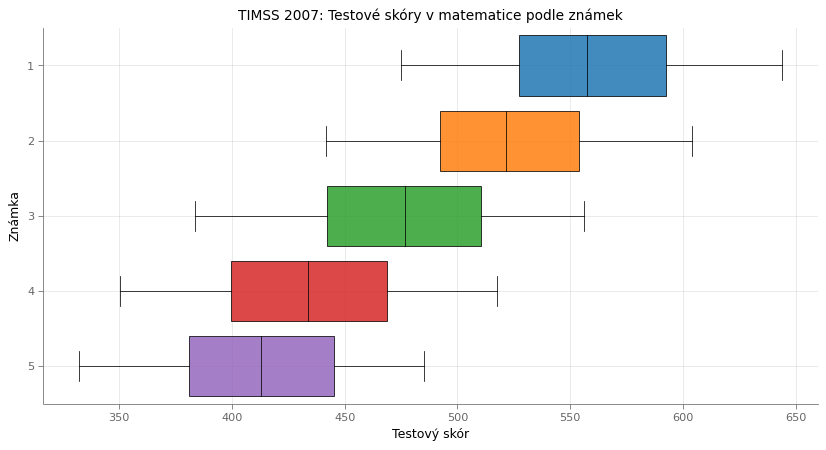

In [215]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=False, positions=range(6, 1, -1), widths=0.8, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

ax.set(title='TIMSS 2007: Testové skóry v matematice podle známek', xlabel='Testový skór', ylabel='Známka')

In [216]:
ax.get_figure().savefig('output/prisnost-znamkovani/14-timss-prumerne-skory-boxploty.png')
ax.get_figure().savefig('output/prisnost-znamkovani/14-timss-prumerne-skory-boxploty.pdf')

[Text(0.5, 1.0, 'TIMSS 2007: Testové skóre v matematice podle známek'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Testové skóre')]

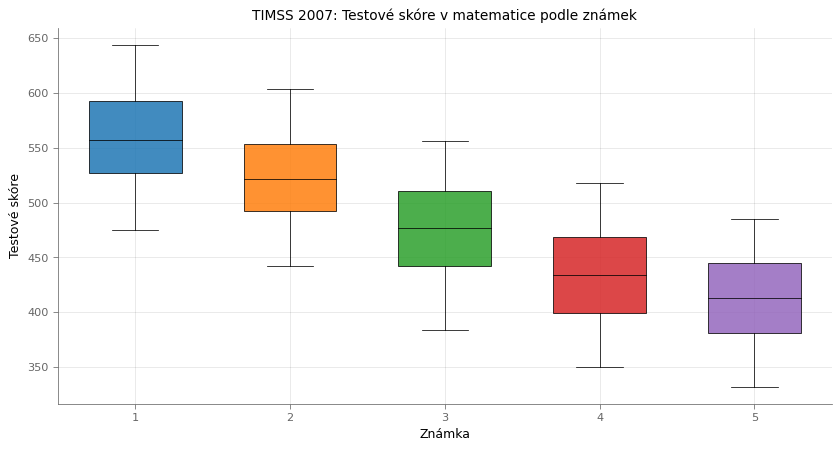

In [12]:
fig, ax = plt.subplots()

props = dict(linewidth=0.6, color='black')
pal = sns.color_palette(n_colors=5)

boxes = ax.bxp(boxplots, vert=True, positions=range(1, 6), widths=0.6, patch_artist=True, medianprops=props, boxprops=dict(linewidth=0.6, edgecolor='black'), whiskerprops=props, capprops=props)
for i, bx in enumerate(boxes['boxes']):
    bx.set_facecolor([*pal[i], 0.85])
None

ax.set(title='TIMSS 2007: Testové skóre v matematice podle známek', xlabel='Známka', ylabel='Testové skóre')

In [13]:
ax.get_figure().savefig('output/prisnost-znamkovani/14-timss-prumerne-skory-boxploty-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/14-timss-prumerne-skory-boxploty-otoceny.pdf')

In [14]:
pd.DataFrame(boxplots).drop(columns=['fliers']).rename(columns={'label': 'grade'})

,grade,med,q1,q3,whislo,whishi
0,1,557.575452,527.456653,592.597229,475.044104,643.973254
1,2,521.463440,492.257727,553.648547,441.913092,603.879187
2,3,476.906897,442.383929,510.306940,383.463470,556.258374
3,4,433.693671,399.601813,468.670386,350.301910,517.696375
4,5,412.787848,381.105878,445.154218,332.124829,485.365717


## Model a přísnost jednotlivých škol

In [135]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ses [pw = wgt3] || idclass: , pweight (wgt12) pwscale(size)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Mixed-effects regression                        Number of obs     =      3,691

Group variable: idclass                         Number of groups  =        197
                                                Obs per group:
                                                              min =          9
                                                              avg =       18.7
                                                              max =         30
                                                Average RVI       =     0.0934
                                                Largest FMI       =     0.2630
DF adjustment:   Large sample                   DF:     min       =      68.44
                                                        avg       =   6,180.93
                                                        max       =  21,093.31
Model F test:       Equal FMI      

In [15]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ses [pw = wgt3] || idclass: , pweight (wgt2) || idschool: , pweight (wgt1)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Mixed-effects regression                        Number of obs     =      3,691

        Grouping information
        -------------------------------------------------------------
                        |     No. of       Observations per group
         Group variable |     groups    Minimum    Average    Maximum
        ----------------+--------------------------------------------
                idclass |        197          9       18.7         30
               idschool |        197          9       18.7         30
        -------------------------------------------------------------

                                                Average RVI       =     0.0860
                                                Largest FMI       =     0.2512
DF adjustment:   Large sample                   DF:     min       =      74.69
                                                        

In [16]:
coefs = stata.get_ereturn()['e(b_mi)'][0]

In [17]:
coefs

array([ -0.78344418,  -0.27943248,  -0.08467866,   2.59157101,
        -1.1444666 , -12.55694452,  -0.3908234 ])

In [20]:
df['gr_matematika_pred'] = coefs[3] + coefs[1] * df['girl'] + coefs[0] * df['MATH_Z'] + coefs[2] * df['ses']
df['gr_matematika_resid'] = df['gr_matematika'] - df['gr_matematika_pred']

In [21]:
n_bins = 4

# ať to můžu pouštět opakovaně
df = df.drop(columns=['prisnost', 'prisnost_bin'], errors='ignore')

sch_resid = df.groupby('idclass')[['gr_matematika_resid', 'wgt12', 'wgt3']]\
    .apply(nanaverage, weights='wgt3')\
    .rename(columns={'gr_matematika_resid': 'prisnost'})\
    .reset_index()

dsw = DescrStatsW(sch_resid['prisnost'], weights=sch_resid['wgt12'])
qs = dsw.quantile(np.arange(1, n_bins) / n_bins)
sch_resid['prisnost_bin'] = pd.cut(sch_resid['prisnost'], [-np.inf] + list(qs) + [np.inf], labels=False)

# hack to flatten the middle two --> this is the best I think - přísné, shovívavé, neutrální
sch_resid['prisnost_bin'] = np.round(2 * sch_resid['prisnost_bin'] / 3)

df = pd.merge(df, sch_resid.drop(columns=['wgt12']))

### Přísnost do Staty

In [22]:
stata.pdataframe_to_frame(sch_resid.drop(columns=['wgt12']), 'classes')

In [23]:
%%stata
frame dir
frlink m:1 idclass, frame(classes idclass)
frget(prisnost prisnost_bin), from(classes)
tab prisnost_bin


. frame dir
* classes  197 x 3
* default  4252 x 437; czt07_zak8.dta

Note: Frames marked with * contain unsaved data.

. frlink m:1 idclass, frame(classes idclass)
  (all observations in frame default matched)

. frget(prisnost prisnost_bin), from(classes)
  (2 variables copied from linked frame)

. tab prisnost_bin

prisnost_bi |
          n |      Freq.     Percent        Cum.
------------+-----------------------------------
          0 |        875       20.58       20.58
          1 |      2,220       52.21       72.79
          2 |      1,157       27.21      100.00
------------+-----------------------------------
      Total |      4,252      100.00

. 


### Charakteristiky skupin přísnosti

In [24]:
sch_resid['prisnost'].min(), sch_resid['prisnost'].max()

(-0.8115706400570077, 1.095626462776868)

/mnt/d/projects/idea/code/venv/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


[Text(0.5, 0, 'Přísnost známkování'),
 Text(0, 0.5, 'Vážená četnost'),
 Text(0.5, 1.0, 'TIMSS 2007: Třídy podle přísnosti')]

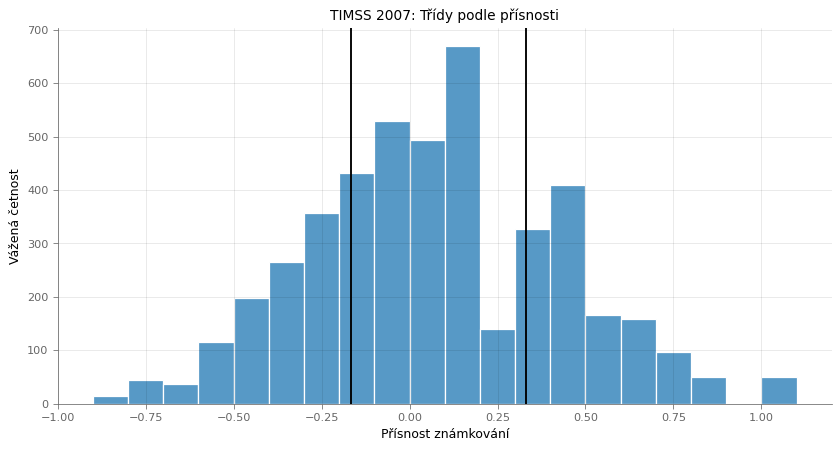

In [29]:
fig, ax = plt.subplots()
bins = np.arange(-0.9, 1.2, step=0.1)
sns.histplot(x='prisnost', weights='wgt12', data=sch_resid, bins=bins, edgecolor='white')
ax.axvline(qs[0.25], color='black', lw=1.5)
ax.axvline(qs[0.75], color='black', lw=1.5)
ax.set(xlabel='Přísnost známkování', ylabel='Vážená četnost', title='TIMSS 2007: Třídy podle přísnosti')

/mnt/d/projects/idea/code/venv/lib/python3.10/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


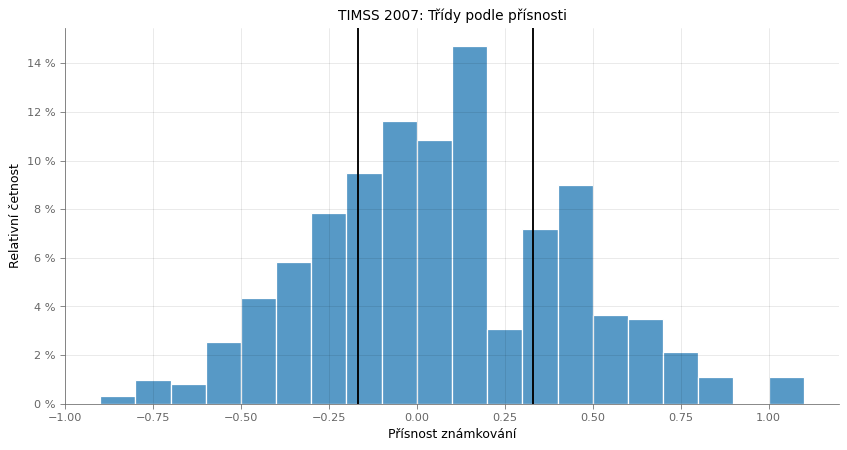

In [30]:
fig, ax = plt.subplots()
bins = np.arange(-0.9, 1.2, step=0.1)
sns.histplot(x='prisnost', weights='wgt12', data=sch_resid, bins=bins, edgecolor='white', stat='percent')
ax.axvline(qs[0.25], color='black', lw=1.5)
ax.axvline(qs[0.75], color='black', lw=1.5)
ax.set(xlabel='Přísnost známkování', ylabel='Relativní četnost', title='TIMSS 2007: Třídy podle přísnosti')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

In [31]:
fig.savefig('output/prisnost-znamkovani/15-timss-rozlozeni-prisnosti.png')
fig.savefig('output/prisnost-znamkovani/15-timss-rozlozeni-prisnosti.pdf')

In [32]:
sch_resid.groupby('prisnost_bin')[['prisnost', 'wgt12']].apply(nanaverage, weights='wgt12')

,prisnost
prisnost_bin,
0.0,-0.368768
1.0,0.056766
2.0,0.546533


In [33]:
foo = sch_resid.copy()
foo['fbin'] = pd.cut(foo['prisnost'], bins)
foo.groupby('fbin')['wgt12'].sum().reset_index()

,fbin,wgt12
0,"(-0.9, -0.8]",13.755655
1,"(-0.8, -0.7]",44.099037
2,"(-0.7, -0.6]",36.455315
3,"(-0.6, -0.5]",116.202987
4,"(-0.5, -0.4]",198.058488
5,"(-0.4, -0.3]",265.845554
6,"(-0.3, -0.2]",357.932212
7,"(-0.2, -0.1]",431.102474
8,"(-0.1, -2.22e-16]",529.197864
9,"(-2.22e-16, 0.1]",493.803730


In [246]:
qs[0.25], qs[0.75]

(-0.1658478735293069, 0.3311958603469094)

[Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Průměrný skór'),
 Text(0.5, 1.0, 'TIMSS 2007: Průměrné testové skóry z matematiky podle známek a přísnosti tříd')]

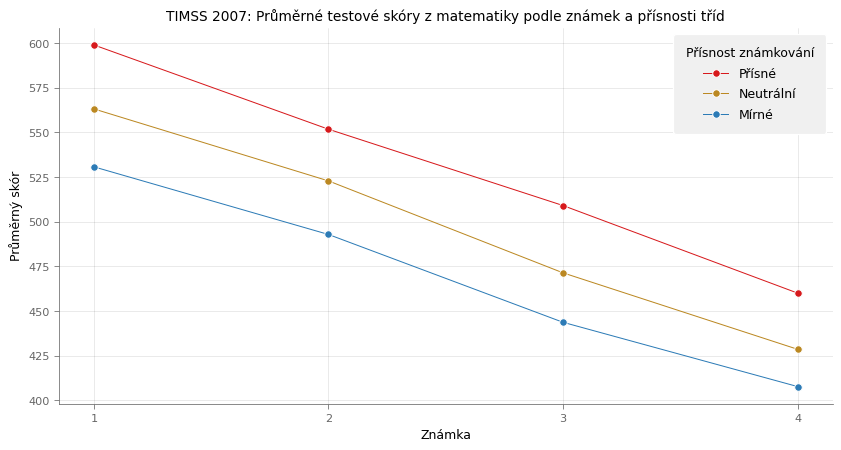

In [240]:
# df.groupby(['gr_matematika', 'SCH_BIN', 'ST225Q06HA'])['CNTSTUID'].count()
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

foo = df.groupby(['gr_matematika', 'prisnost_bin'])[['MATH_MEAN', 'chcevs', 'totwgt', 'bsmj', 'bsmj88']].apply(nanaverage, weights='totwgt').reset_index()
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo = foo[foo['gr_matematika'] != 5]
foo['gr_matematika'] = foo['gr_matematika'].apply(lambda x: f'{x:.0g}')
ax = sns.lineplot(x='gr_matematika', y='MATH_MEAN', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(xlabel='Známka', ylabel='Průměrný skór', title='TIMSS 2007: Průměrné testové skóry z matematiky podle známek a přísnosti tříd')

In [97]:
%stata mi estimate, dots: reg math ibn.gr_matematika#ibn.prisnost_bin ses girl, noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      3,691
                                                Average RVI       =     0.4205
                                                Largest FMI       =     0.5272
                                                Complete DF       =       3674
DF adjustment:   Small sample                   DF:     min       =      17.47
                                                        avg       =      82.24
                                                        max       =     358.85
Model F test:       Equal FMI                   F(  17,  589.4)   =   19112.99
Within VCE type:          OLS                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

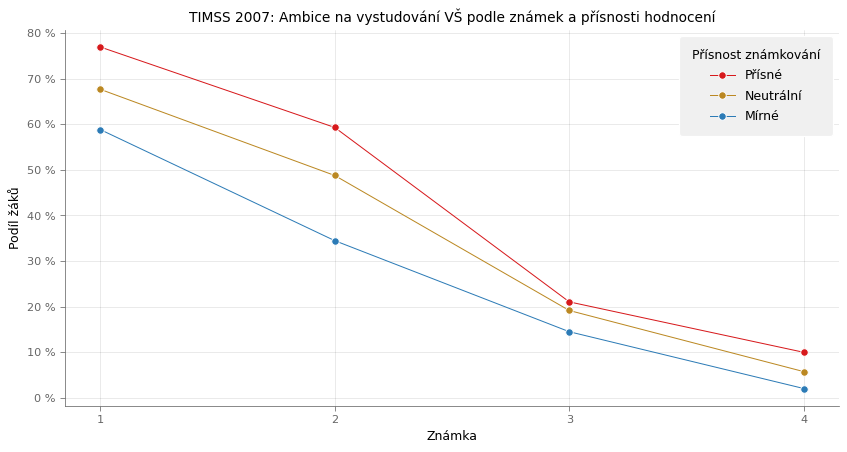

In [134]:
foo['chcevsx100'] = 100 * foo['chcevs']
ax = sns.lineplot(x='gr_matematika', y='chcevsx100', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='TIMSS 2007: Ambice na vystudování VŠ podle známek a přísnosti hodnocení', xlabel='Známka', ylabel='Podíl žáků')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))

In [98]:
%stata mi estimate, dots: logit chcevs i.gr_matematika#ib1.prisnost_bin ses girl, noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,276
                                                Average RVI       =     0.0000
                                                Largest FMI       =     0.0000
DF adjustment:   Large sample                   DF:     min       =   2.48e+62
                                                        avg       =   5.24e+63
                                                        max       =          .
Model F test:       Equal FMI                   F(  14, 3.8e+65)  =      50.13
Within VCE type:          OIM                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a#|
pris

In [104]:
%stata mi estimate, dots: logit chcevs mathz ib1.prisnost_bin ses girl [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,384
                                                Average RVI       =     0.0990
                                                Largest FMI       =     0.3438
DF adjustment:   Large sample                   DF:     min       =      40.95
                                                        avg       =   4,027.71
                                                        max       =   9,678.28
Model F test:       Equal FMI                   F(   5, 1300.8)   =      87.18
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz |    1

In [111]:
np.round([logistic(-0.141 * 1.163 - 0.835 + 0.105), logistic(-0.141 * 1.163 - 0.835), logistic(-0.141 * 1.163 - 0.835 - 0.416)], 3)

array([0.29 , 0.269, 0.195])

In [112]:
np.round([logistic(-0.166 * 1.163 - 0.835 + 0.105 + 0.419), logistic(-0.166 * 1.163 - 0.835 + 0.419), logistic(-0.166 * 1.163 - 0.835 - 0.416 + 0.419)], 3)

array([0.377, 0.352, 0.264])

In [105]:
%stata mi estimate, dots: reg mathz girl [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.0740
                                                Largest FMI       =     0.1201
                                                Complete DF       =       4250
DF adjustment:   Small sample                   DF:     min       =     283.11
                                                        avg       =     338.61
                                                        max       =     394.12
Model F test:       Equal FMI                   F(   1,  283.1)   =       0.61
Within VCE type:       Robust                   Prob > F          =     0.4346

------------------------------------------------------------------------------
       mathz | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

[Text(0.5, 1.0, 'Očekávaný socioekonomický status zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Status zaměstnání')]

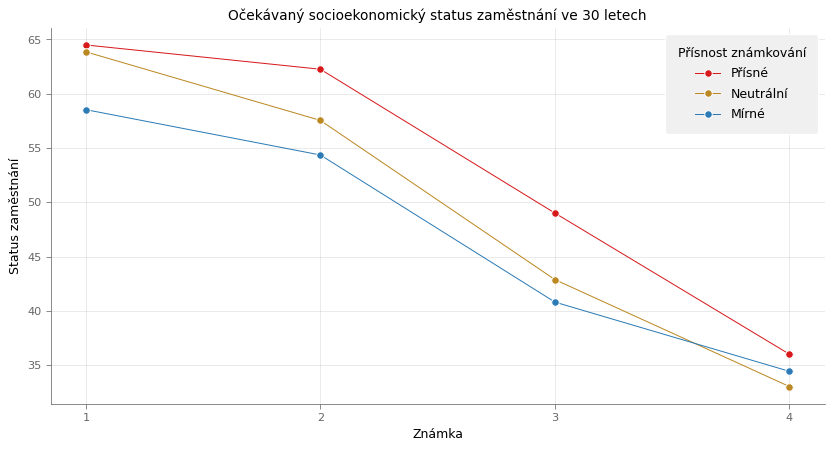

In [87]:
ax = sns.lineplot(x='gr_matematika', y='bsmj', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='Očekávaný socioekonomický status zaměstnání ve 30 letech', xlabel='Známka', ylabel='Status zaměstnání')

[Text(0.5, 1.0, 'Očekávaný socioekonomický status zaměstnání ve 30 letech'),
 Text(0.5, 0, 'Známka'),
 Text(0, 0.5, 'Status zaměstnání')]

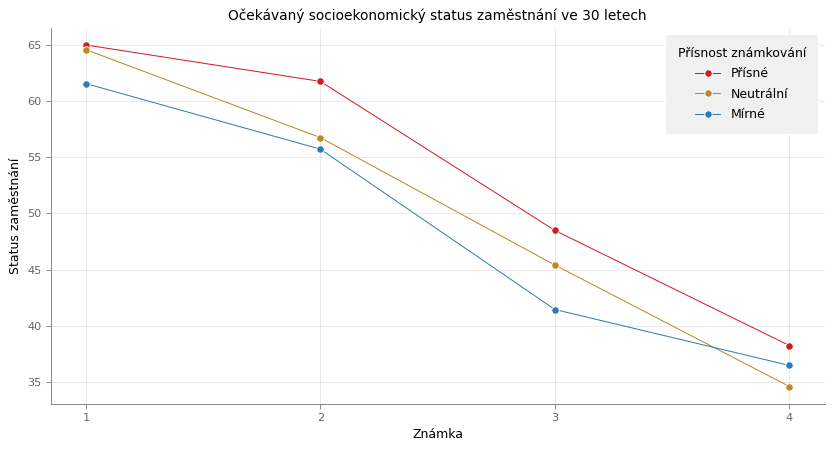

In [88]:
ax = sns.lineplot(x='gr_matematika', y='bsmj88', data=foo, hue='prisnost_group', marker='o', palette=prisnost_pal, hue_order=prisnost_order)
ax.legend(ax.lines[:3], ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set(title='Očekávaný socioekonomický status zaměstnání ve 30 letech', xlabel='Známka', ylabel='Status zaměstnání')

[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

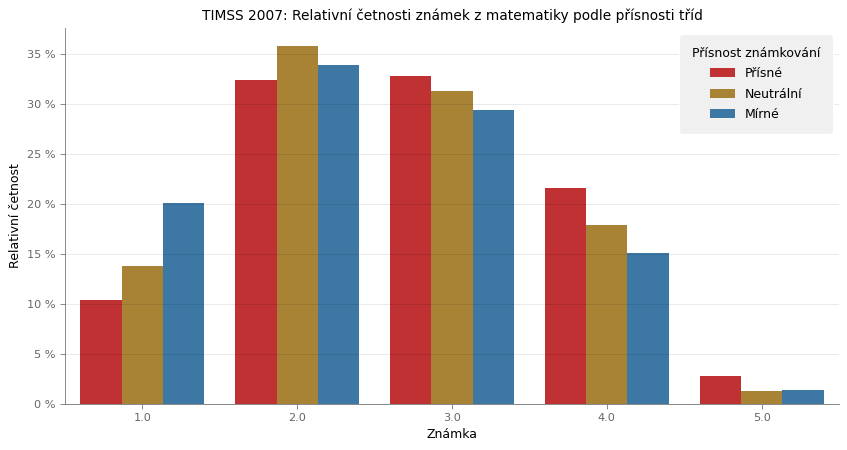

In [241]:
foo = df.groupby(['gr_matematika', 'prisnost_bin'])['totwgt'].sum().reset_index()
foo = pd.merge(foo, foo.groupby('prisnost_bin')['totwgt'].sum().rename('totwgt_TOTAL').reset_index())
foo['prisnost_group'] = pd.Categorical(foo['prisnost_bin'])
foo['rel_weight'] = 100 * foo['totwgt'] / foo['totwgt_TOTAL']
ax = sns.barplot(x='gr_matematika', y='rel_weight', hue='prisnost_group', data=foo, palette=prisnost_pal, hue_order=prisnost_order)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles, ('Přísné', 'Neutrální', 'Mírné'), title='Přísnost známkování')
ax.set_title('TIMSS 2007: Relativní četnosti známek z matematiky podle přísnosti tříd')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

In [242]:
ax.get_figure().savefig('output/prisnost-znamkovani/16-timss-cetnosti-znamek-podle-prisnosti.png')
ax.get_figure().savefig('output/prisnost-znamkovani/16-timss-cetnosti-znamek-podle-prisnosti.pdf')

In [243]:
foo

,gr_matematika,prisnost_bin,totwgt,totwgt_TOTAL,prisnost_group,rel_weight
0,1.0,0.0,4862.632825,24181.569006,0.0,20.108839
1,2.0,0.0,8203.808538,24181.569006,0.0,33.925874
2,3.0,0.0,7123.774767,24181.569006,0.0,29.459523
3,4.0,0.0,3649.922903,24181.569006,0.0,15.093822
4,5.0,0.0,341.429973,24181.569006,0.0,1.411943
5,1.0,1.0,7062.859722,51293.165883,1.0,13.769592
6,2.0,1.0,18386.619796,51293.165883,1.0,35.846139
7,3.0,1.0,16050.920954,51293.165883,1.0,31.292514
8,4.0,1.0,9157.495999,51293.165883,1.0,17.853248
9,5.0,1.0,635.269412,51293.165883,1.0,1.238507


In [58]:
%stata mi estimate, dots: reg math ibn.prisnost_bin [pw = totwgt], noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      4,252
                                                Average RVI       =     0.0973
                                                Largest FMI       =     0.1332
                                                Complete DF       =       4249
DF adjustment:   Small sample                   DF:     min       =     234.99
                                                        avg       =   1,013.39
                                                        max       =   2,492.67
Model F test:       Equal FMI                   F(   3,  626.0)   =   62360.09
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
        math | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [59]:
%stata mi estimate, dots: reg ses ibn.prisnost_bin [pw = totwgt], noconstant


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      3,691
                                                Average RVI       =     0.0000
                                                Largest FMI       =     0.0000
                                                Complete DF       =       3688
DF adjustment:   Small sample                   DF:     min       =   3,686.00
                                                        avg       =   3,686.00
                                                        max       =   3,686.00
Model F test:       Equal FMI                   F(   3, 3686.0)   =      17.26
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
         ses | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [29]:
er = stata.get_ereturn()
coefs = er['e(b_mi)']
std_errs = np.sqrt(np.diag(er['e(V_mi)']))
dfr = er['e(df_r)']
foo = pd.DataFrame({'coef': coefs[0], 'se': std_errs})

blbls = ['Mírné', 'Neutrální', 'Přísné']

foo['lc'] = foo['coef'] + scipy.stats.t.ppf(0.025, dfr) * foo['se']
foo['uc'] = foo['coef'] + scipy.stats.t.ppf(0.975, dfr) * foo['se']
foo['prisnost_bin'] = foo.index
foo['label'] = foo['prisnost_bin'].apply(lambda x: blbls[int(x)])
foo = foo.sort_values('prisnost_bin', ascending=False).reset_index(drop=True)
foo

,coef,se,lc,uc,prisnost_bin,label
0,517.405143,2.386988,512.725400,522.084887,2,Přísné
1,494.019583,1.543065,490.994369,497.044796,1,Neutrální
2,472.293435,2.502014,467.388179,477.198691,0,Mírné


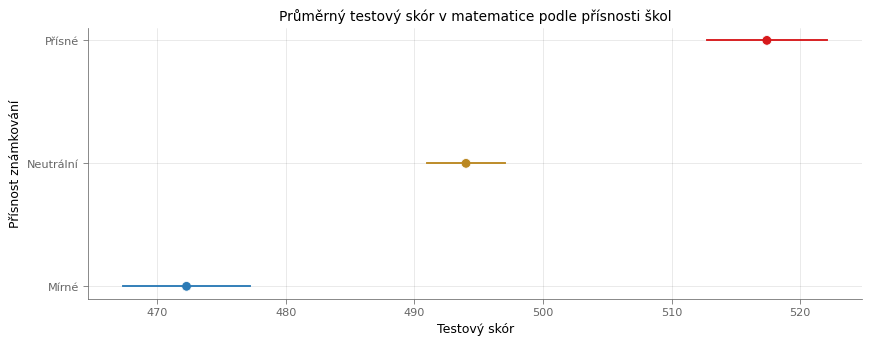

In [30]:
fig, ax = plt.subplots(figsize=(10, 3.6))
sns.scatterplot(x='coef', y='label', data=foo, hue='prisnost_bin', hue_order=[2, 1, 0], palette=prisnost_pal, legend=False, s=60)
for i in range(3):
    plt.plot(foo.loc[i, ['lc', 'uc']], [i, i], color=prisnost_pal[i], lw=1.5)
ax.set(xlabel='Testový skór', ylabel='Přísnost známkování', title='Průměrný testový skór v matematice podle přísnosti škol')
None

### Model pro VŠ a status zaměstnání

In [34]:
%stata sum ses


    Variable |        Obs        Mean    Std. dev.       Min        Max
-------------+---------------------------------------------------------
         ses |      3,691    1.75e-09           1  -3.566226    2.41323


In [35]:
%stata gen ses_high = ses > 0

In [36]:
%stata mi estimate, dots: logit chcevs mathz ib1.prisnost_bin ses_high girl [pw = totwgt], vce(cl idclass)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,805
                                                Average RVI       =     0.0783
                                                Largest FMI       =     0.2913
DF adjustment:   Large sample                   DF:     min       =      56.31
                                                        avg       =   5,449.92
                                                        max       =  14,450.81
Model F test:       Equal FMI                   F(   5, 1862.9)   =      62.81
Within VCE type:       Robust                   Prob > F          =     0.0000

                             (Within VCE adjusted for 197 clusters in idclass)
------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+-----

In [37]:
er = stata.get_ereturn()

In [38]:
coefs = er['e(b_mi)'][0]
coefs

array([ 1.20399175,  0.07446811,  0.        , -0.32464522,  0.82075877,
        0.35521315, -1.24069678])

In [39]:
foo = pd.merge(pd.Series([0, 1], name='high_ses'), pd.Series([0, 1], name='girl'), how='cross')

foo['gender'] = np.where(foo['girl'], 'Dívka', 'Chlapec')
foo['label'] = foo.apply(lambda x: ('Dívka, ' if x['girl'] else 'Chlapec, ') + ('vysoký SES' if x['high_ses'] else 'nízký ses'), axis=1)

foo['logit_g1'] = coefs[6] + foo['girl'] * coefs[5] + foo['high_ses'] * coefs[4]
foo['logit_g0'] = foo['logit_g1'] + coefs[1]
foo['logit_g2'] = foo['logit_g1'] + coefs[3]

foo['prob_g1'] = logistic(foo['logit_g1']) * 100
foo['prob_g0'] = logistic(foo['logit_g0']) * 100
foo['prob_g2'] = logistic(foo['logit_g2']) * 100

foo = foo[::-1].reset_index(drop=True)

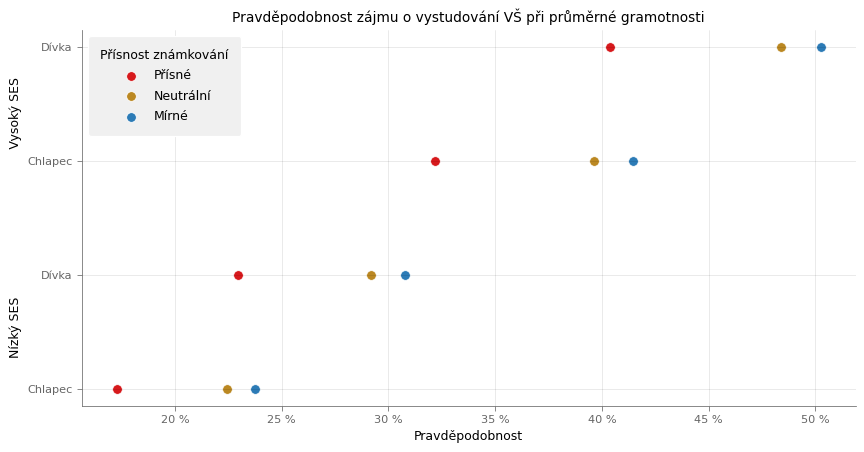

In [41]:
# cur_palette = sns.color_palette(n_colors=2)
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

fig, ax = plt.subplots()
sns.scatterplot(data=foo, y='label', x='prob_g2', color=prisnost_pal[0], label='Přísné', s=60)
sns.scatterplot(data=foo, y='label', x='prob_g1', color=prisnost_pal[1], label='Neutrální', s=60)
sns.scatterplot(data=foo, y='label', x='prob_g0', color=prisnost_pal[2], label='Mírné', s=60)

ax.set(xlabel='Pravděpodobnost', ylabel='', title='Pravděpodobnost zájmu o vystudování VŠ při průměrné gramotnosti')  # , xlim=(0, 100))
ax.set(ylabel='Nízký SES                                     Vysoký SES')
ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
plt.yticks([0, 1, 2, 3], 2 * ['Dívka', 'Chlapec'])
plt.legend(title='Přísnost známkování')

In [274]:
ax.get_figure().savefig('output/prisnost-znamkovani/17-timss-vs-ambice-prisnost.png')
ax.get_figure().savefig('output/prisnost-znamkovani/17-timss-vs-ambice-prisnost.pdf')

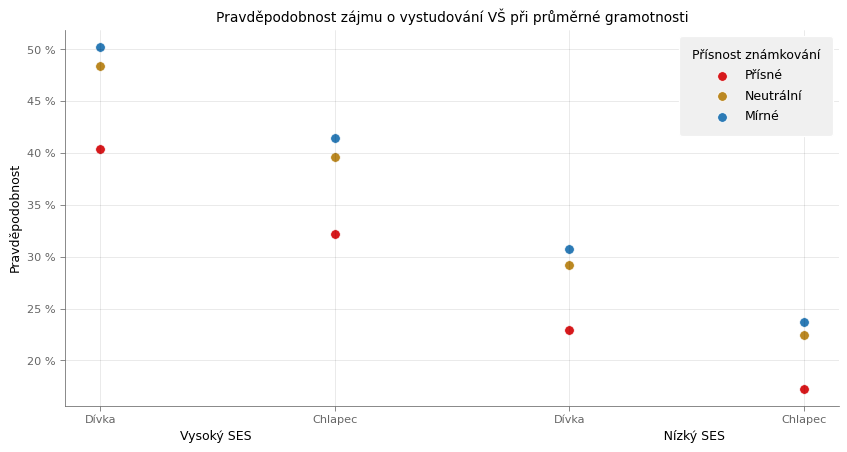

In [42]:
# cur_palette = sns.color_palette(n_colors=2)
prisnost_pal = ['#d7191c', '#bb8822', '#2c7bb6']
prisnost_order = [2, 1, 0]

fig, ax = plt.subplots()
sns.scatterplot(data=foo, x='label', y='prob_g2', color=prisnost_pal[0], label='Přísné', s=60)
sns.scatterplot(data=foo, x='label', y='prob_g1', color=prisnost_pal[1], label='Neutrální', s=60)
sns.scatterplot(data=foo, x='label', y='prob_g0', color=prisnost_pal[2], label='Mírné', s=60)

ax.set(ylabel='Pravděpodobnost', xlabel='', title='Pravděpodobnost zájmu o vystudování VŠ při průměrné gramotnosti')  # , xlim=(0, 100))
ax.set(xlabel='Vysoký SES                                                                                                       Nízký SES')
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
plt.xticks([0, 1, 2, 3], 2 * ['Dívka', 'Chlapec'])
plt.legend(title='Přísnost známkování')

In [43]:
ax.get_figure().savefig('output/prisnost-znamkovani/17-timss-vs-ambice-prisnost-otoceny.png')
ax.get_figure().savefig('output/prisnost-znamkovani/17-timss-vs-ambice-prisnost-otoceny.pdf')

In [44]:
foo

,high_ses,girl,gender,label,logit_g1,logit_g0,logit_g2,prob_g1,prob_g0,prob_g2
0,1,1,Dívka,"Dívka, vysoký SES",-0.064725,0.009743,-0.389370,48.382443,50.243579,40.386895
1,1,0,Chlapec,"Chlapec, vysoký SES",-0.419938,-0.345470,-0.744583,39.653158,41.448139,32.200273
2,0,1,Dívka,"Dívka, nízký ses",-0.885484,-0.811016,-1.210129,29.204273,30.767414,22.967825
3,0,0,Chlapec,"Chlapec, nízký ses",-1.240697,-1.166229,-1.565342,22.431472,23.753734,17.288144


In [259]:
%stata mi estimate, dots: reg bsmj mathz ib1.prisnost_bin ses_high girl [pw = totwgt], vce(cl idclass)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Linear regression                               Number of obs     =      1,677
                                                Average RVI       =     0.0860
                                                Largest FMI       =     0.3020
                                                Complete DF       =        196
DF adjustment:   Small sample                   DF:     min       =      38.62
                                                        avg       =     150.26
                                                        max       =     192.72
Model F test:       Equal FMI                   F(   5,  172.1)   =      96.27
Within VCE type:       Robust                   Prob > F          =     0.0000

                             (Within VCE adjusted for 197 clusters in idclass)
------------------------------------------------------------------------------
        bsmj | Coef

In [260]:
er = stata.get_ereturn()

In [261]:
coefs = er['e(b_mi)'][0]
coefs

array([10.46262903,  2.42533962,  0.        , -1.35491343,  4.21126188,
        0.76105551, 48.2845502 ])

In [262]:
foo = pd.merge(pd.Series([0, 1], name='high_ses'), pd.Series([0, 1], name='girl'), how='cross')

foo['gender'] = np.where(foo['girl'], 'Dívka', 'Chlapec')
foo['label'] = foo.apply(lambda x: ('Dívka, ' if x['girl'] else 'Chlapec, ') + ('vysoký SES' if x['high_ses'] else 'nízký ses'), axis=1)

foo['bsmj_g1'] = coefs[6] + foo['girl'] * coefs[5] + foo['high_ses'] * coefs[4]
foo['bsmj_g0'] = foo['bsmj_g1'] + coefs[1]
foo['bsmj_g2'] = foo['bsmj_g1'] + coefs[3]

foo = foo[::-1].reset_index(drop=True)

[Text(0, 0.5, 'Nízký SES                                     Vysoký SES')]

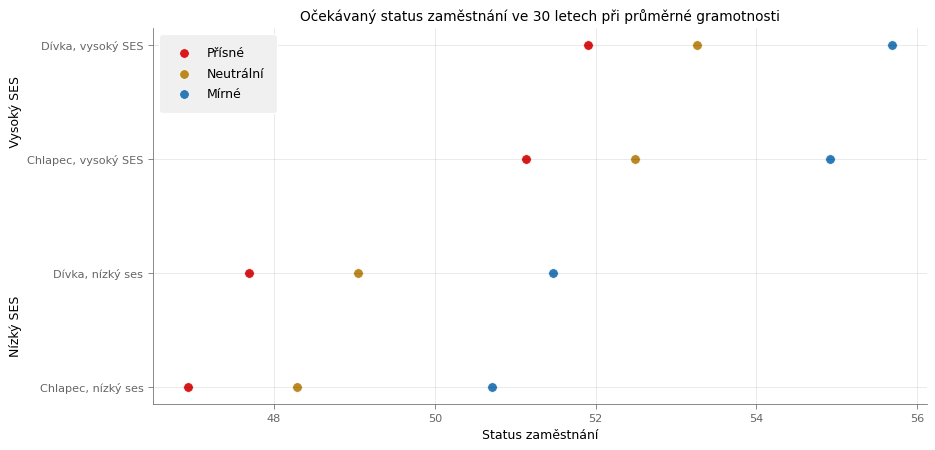

In [263]:
# cur_palette = sns.color_palette(n_colors=2)

fig, ax = plt.subplots()
sns.scatterplot(data=foo, y='label', x='bsmj_g2', color=prisnost_pal[0], label='Přísné', s=60)
sns.scatterplot(data=foo, y='label', x='bsmj_g1', color=prisnost_pal[1], label='Neutrální', s=60)
sns.scatterplot(data=foo, y='label', x='bsmj_g0', color=prisnost_pal[2], label='Mírné', s=60)

ax.set(xlabel='Status zaměstnání', ylabel='', title='Očekávaný status zaměstnání ve 30 letech při průměrné gramotnosti')  # , xlim=(0, 100))
ax.set(ylabel='Nízký SES                                     Vysoký SES')

In [60]:
%stata mi estimate, dots: logit chcevs gr_matematika_z mathz girl ses [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,384
                                                Average RVI       =     0.1024
                                                Largest FMI       =     0.3621
DF adjustment:   Large sample                   DF:     min       =      37.05
                                                        avg       =   8,658.37
                                                        max       =  16,724.42
Model F test:       Equal FMI                   F(   4,  744.8)   =     113.33
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z |  -.7

In [76]:
%stata mi estimate, dots: logit chcevs gr_matematika_z mathz girl ses ib1.prisnost_bin [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,384
                                                Average RVI       =     0.0880
                                                Largest FMI       =     0.4067
DF adjustment:   Large sample                   DF:     min       =      29.56
                                                        avg       =   9,457.75
                                                        max       =  30,313.83
Model F test:       Equal FMI                   F(   6, 2014.5)   =      77.04
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~z |  -.8

In [80]:
%stata mi estimate, dots: logit chcevs i.gr_matematika#i.prisnost_bin mathz girl ses [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,276
                                                Average RVI       =     0.0466
                                                Largest FMI       =     0.4299
DF adjustment:   Large sample                   DF:     min       =      26.51
                                                        avg       = 190,949.25
                                                        max       = 2108448.98
Model F test:       Equal FMI                   F(  15,23900.4)   =      36.68
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
gr_matemat~a#|
pris

In [83]:
%stata mi estimate, dots: logit chcevs mathz ib1.prisnost_bin girl ses [pw = totwgt]


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Logistic regression                             Number of obs     =      3,384
                                                Average RVI       =     0.0990
                                                Largest FMI       =     0.3438
DF adjustment:   Large sample                   DF:     min       =      40.95
                                                        avg       =   4,027.71
                                                        max       =   9,678.28
Model F test:       Equal FMI                   F(   5, 1300.8)   =      87.18
Within VCE type:       Robust                   Prob > F          =     0.0000

------------------------------------------------------------------------------
      chcevs | Coefficient  Std. err.      t    P>|t|     [95% conf. interval]
-------------+----------------------------------------------------------------
       mathz |    1

In [ ]:
%stata mi estimate, dots: logit chcevs mathz ib1.prisnost_bin girl ses [pw = totwgt]

In [136]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ses [pw = wgt3] || idclass: , pweight (wgt12) pwscale(size)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Mixed-effects regression                        Number of obs     =      3,691

Group variable: idclass                         Number of groups  =        197
                                                Obs per group:
                                                              min =          9
                                                              avg =       18.7
                                                              max =         30
                                                Average RVI       =     0.0934
                                                Largest FMI       =     0.2630
DF adjustment:   Large sample                   DF:     min       =      68.44
                                                        avg       =   6,180.93
                                                        max       =  21,093.31
Model F test:       Equal FMI      

In [138]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ses [pw = wgt3] || idclass: , pweight (wgt2) || idschool: , pweight (wgt1)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Mixed-effects regression                        Number of obs     =      3,691

        Grouping information
        -------------------------------------------------------------
                        |     No. of       Observations per group
         Group variable |     groups    Minimum    Average    Maximum
        ----------------+--------------------------------------------
                idclass |        197          9       18.7         30
               idschool |        197          9       18.7         30
        -------------------------------------------------------------

                                                Average RVI       =     0.0860
                                                Largest FMI       =     0.2512
DF adjustment:   Large sample                   DF:     min       =      74.69
                                                        

In [139]:
%stata mi estimate, dots: mixed gr_matematika mathz girl ses [pw = wgt3] || idclass: , pweight (wgt12)


Imputations (5):
  ..... done

Multiple-imputation estimates                   Imputations       =          5
Mixed-effects regression                        Number of obs     =      3,691

Group variable: idclass                         Number of groups  =        197
                                                Obs per group:
                                                              min =          9
                                                              avg =       18.7
                                                              max =         30
                                                Average RVI       =     0.0899
                                                Largest FMI       =     0.2472
DF adjustment:   Large sample                   DF:     min       =      77.00
                                                        avg       =   6,809.54
                                                        max       =  22,609.82
Model F test:       Equal FMI      

In [140]:
df.shape

(4252, 448)

In [141]:
dsw = DescrStatsW(df['gr_matematika'], weights=df['totwgt'])

In [143]:
dsw.__dict__

{'data': array([3., 3., 4., ..., 2., 3., 4.]),
 'weights': array([19.64444542, 19.64444542, 19.64444542, ..., 40.36746979,
        40.36746979, 40.36746979]),
 'ddof': 0}

In [145]:
dsw.std

0.9975204461618076

[Text(0.5, 0, 'Známka'), Text(0, 0.5, 'Relativní četnost')]

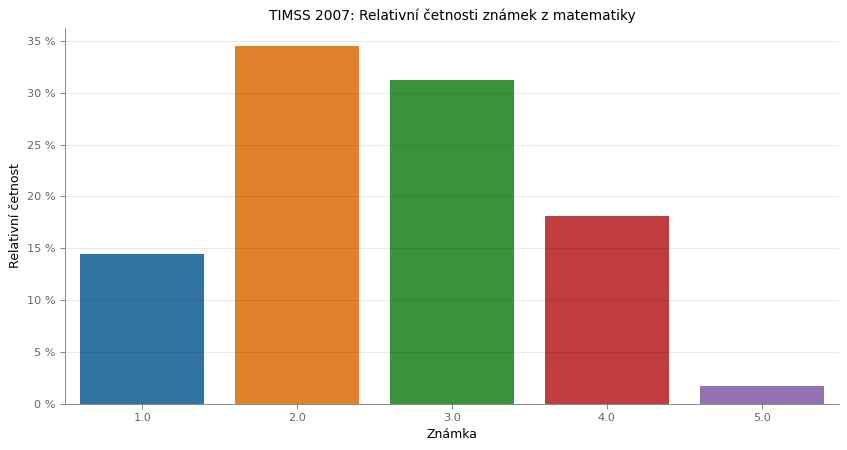

In [146]:
foo = df.groupby('gr_matematika')['totwgt'].sum().reset_index()
totwgt_total = foo['totwgt'].sum()
foo['rel_weight'] = 100 * foo['totwgt'] / totwgt_total
ax = sns.barplot(x='gr_matematika', y='rel_weight', data=foo)
ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0, symbol=' %'))
ax.set_title('TIMSS 2007: Relativní četnosti známek z matematiky')
ax.set(xlabel='Známka', ylabel='Relativní četnost')

In [147]:
df.columns

Index(['idcntry', 'idschool', 'idclass', 'idgrade', 'idstud', 'itbirthm',
       'itbirthy', 'itsex', 'idbook', 'itadmini',
       ...
       'bsmmat02z', 'bsmmat03z', 'bsmmat04z', 'bsmmat05z', 'MATH_MEAN',
       'MATH_Z', 'gr_matematika_pred', 'gr_matematika_resid', 'prisnost',
       'prisnost_bin'],
      dtype='object', length=448)

In [148]:
df.shape

(4252, 448)

In [149]:
df['idcntry'].value_counts()

203    4252
Name: idcntry, dtype: int64

In [150]:
df['idgrade'].value_counts()

8    4252
Name: idgrade, dtype: int64

In [153]:
df['idclass'].value_counts().value_counts()

23    24
21    21
22    21
17    17
25    15
26    14
20    14
19    14
24    13
18     8
27     7
28     6
16     6
15     5
29     4
14     4
13     2
30     1
11     1
Name: idclass, dtype: int64

In [156]:

df['idschool'].value_counts().sort_values()

60      11
163     13
1044    13
19      14
282     14
        ..
270     52
211     53
78      54
83      56
38      56
Name: idschool, Length: 133, dtype: int64

In [47]:
df[['idschool', 'idclass']].drop_duplicates()['idschool'].value_counts().sort_values()

240    1
101    1
103    1
105    1
111    1
      ..
38     2
36     2
211    2
207    2
175    2
Name: idschool, Length: 133, dtype: int64